*Let's load all Billboard Hot 100 Charts from our chart data into one dataframe.*

In [ ]:

import pandas as pd
import os

years = ["2022", "2023", "2024", "2025"]

hot_100 = pd.DataFrame()

for year in years:

    file_count = 0
    
    for file in os.listdir(f"chart_data/hot-100/{year}"):

        hot_100 = pd.concat([hot_100, pd.read_csv(f"chart_data/hot-100/{year}/{file}")])
        file_count += 1
        
    print(f"Added {file_count} files to hot_100 from {year}")

Added 53 files to hot_100 from 2022
Added 52 files to hot_100 from 2023
Added 52 files to hot_100 from 2024
Added 34 files to hot_100 from 2025


*.listdir() doesn't inherently keep sorting, so let's do this now.*

In [23]:
hot_100 = hot_100.sort_values("chart_week", ascending=True).reset_index(drop=True)
hot_100

,chart_week,current_week,title,performer,last_week,peak_pos,wks_on_chart
0,2022-01-01,50,One Right Now,Post Malone & The Weeknd,38,6,7
1,2022-01-01,99,Knowing You,Kenny Chesney,84,57,19
2,2022-01-01,24,Need To Know,Doja Cat,14,8,28
3,2022-01-01,3,Jingle Bell Rock,Bobby Helms,4,3,41
4,2022-01-01,4,A Holly Jolly Christmas,Burl Ives,5,4,25
...,...,...,...,...,...,...,...
19095,2025-08-23,3,What I Want,Morgan Wallen Featuring Tate McRae,4,1,13
19096,2025-08-23,24,What It Sounds Like,"HUNTR/X: EJAE, Audrey Nuna & REI AMI",25,24,7
19097,2025-08-23,26,Takedown,"HUNTR/X: EJAE, Audrey Nuna & REI AMI",29,26,7
19098,2025-08-23,11,I'm The Problem,Morgan Wallen,11,2,28


*Ok, I want to visualize the distribution of the wks_on_chart field, so I need to remove duplicate song rows and leave only the row with greatest count*

In [57]:
weeks_on_chart_df = hot_100
weeks_on_chart_df.sort_values(by="wks_on_chart", ascending=False)
weeks_on_chart_df = weeks_on_chart_df.groupby("title")["wks_on_chart"].max().reset_index()
weeks_on_chart_df

,title,wks_on_chart
0,'98 Braves,7
1,'Til You Can't,36
2,(There's No Place Like) Home For The Holidays,12
3,(There's No Place Like) Home For The Holidays ...,1
4,(There's No Place Like) Home For The Holidays ...,13
...,...,...
2374,imgonnagetyouback,5
2375,like JENNIE,3
2376,loml,7
2377,thanK you aIMee,3


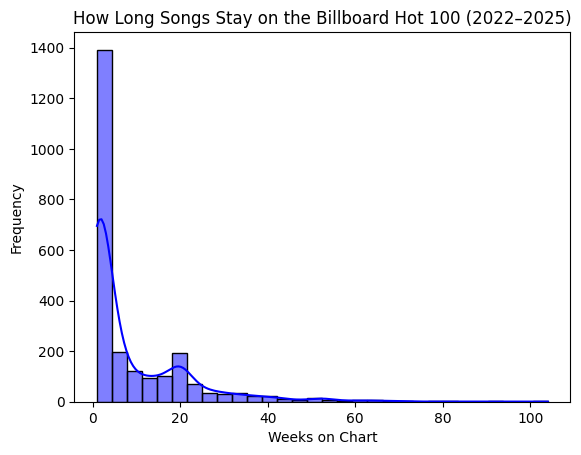

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(weeks_on_chart_df["wks_on_chart"], bins=30, kde=True, color="blue", edgecolor="black")
plt.title("How Long Songs Stay on the Billboard Hot 100 (2022–2025)")
plt.xlabel("Weeks on Chart")
plt.ylabel("Frequency")
plt.show()

*This is great, but if I want to predict a song's wks_on_chart from first week data or prior, we need to remove all songs whose entry week was before our first recorded week (Jan 1st, 2022)*

*Also, the goal is to collect data to use the following predictor variables:*

*- Number of daily UGCs to song's sound(s) (TikTok and Instagram)*

*- SocialBlade Social Media data*

*- Spotify Metadata (Dancability etc.)*

*- Genius Lyrics*

*- Genre-weighted Typicality (Yearly, Monthly) as per Askin and Mauskapf*

*- First week Billboard Hot 100 position*

*- Is the artist associated with the song signed to a major label?*

*- Is the artist in the co-signed by a much larger artist or influencer?*